# Basic GNN

## Import Libraries

In [12]:
import torch
import numpy
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Graph Datasets

In [2]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root="dataset", name="Cora")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


In [3]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root="dataset")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


Processing...
Done!


## Cora Dataset

In [4]:
import pandas as pd

dataset = Planetoid(root="dataset", name="Cora")
data = dataset[0]

df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
df_x

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Torch MLP

In [5]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create MLP model
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

# Train
mlp.fit(data, epochs=100)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch   0 | Train Loss: 1.959 | Train Acc: 14.29% | Val Loss: 2.00 | Val Acc: 12.40%
Epoch  20 | Train Loss: 0.110 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 49.40%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.44 | Val Acc: 51.00%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 53.80%
Epoch  80 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.37 | Val Acc: 55.40%
Epoch 100 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.34 | Val Acc: 54.60%

MLP test accuracy: 53.40%


### Visualization Fuction

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

### VanillaGNN

In [7]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [8]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0].float()
adjacency += torch.eye(len(adjacency))
adjacency


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [9]:
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=0.01,
            weight_decay=5e-4
        )

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(
                out[data.train_mask], 
                data.y[data.train_mask]
            )
            acc = accuracy(
                out[data.train_mask].argmax(dim=1),
                data.y[data.train_mask]
            )
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        visualize(out, color=data.y)
        return acc

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)
Epoch   0 | Train Loss: 1.991 | Train Acc: 15.71% | Val Loss: 2.11 | Val Acc: 9.40%
Epoch  20 | Train Loss: 0.065 | Train Acc: 99.29% | Val Loss: 1.47 | Val Acc: 76.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 2.11 | Val Acc: 75.40%
Epoch  60 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 2.22 | Val Acc: 75.40%
Epoch  80 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 2.20 | Val Acc: 76.80%
Epoch 100 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 2.19 | Val Acc: 77.00%


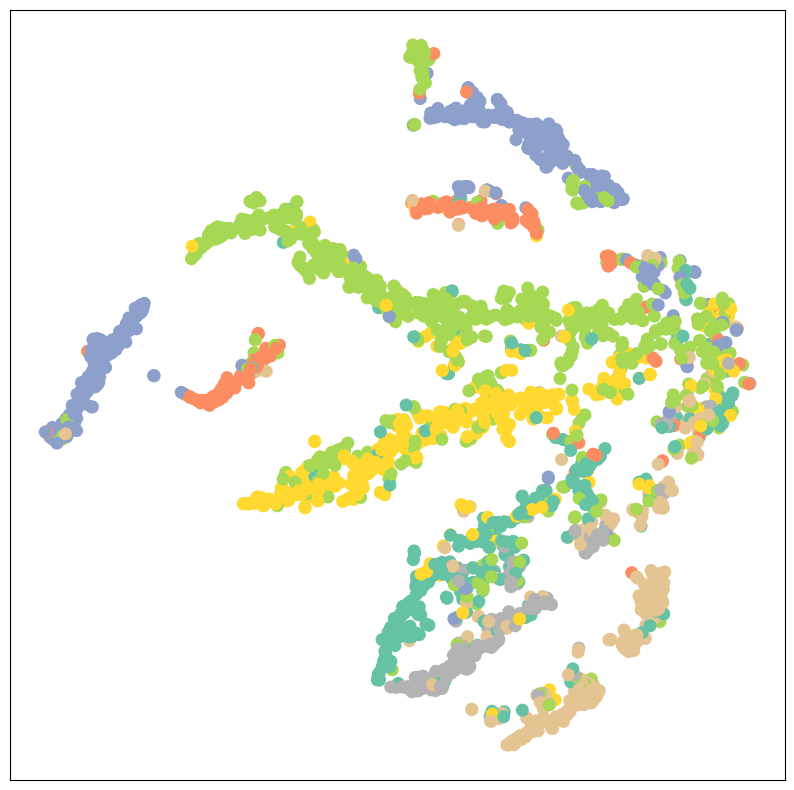


GNN test accuracy: 76.60%


In [10]:
# Create the Vanilla GNN model
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

## GNN: Facebook Page-Page

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.401 | Train Acc: 28.11% | Val Loss: 1.40 | Val Acc: 28.91%
Epoch  20 | Train Loss: 0.671 | Train Acc: 73.47% | Val Loss: 0.68 | Val Acc: 72.94%
Epoch  40 | Train Loss: 0.579 | Train Acc: 76.95% | Val Loss: 0.61 | Val Acc: 74.89%
Epoch  60 | Train Loss: 0.549 | Train Acc: 78.20% | Val Loss: 0.60 | Val Acc: 75.59%
Epoch  80 | Train Loss: 0.533 | Train Acc: 78.76% | Val Loss: 0.60 | Val Acc: 75.39%
Epoch 100 | Train Loss: 0.520 | Train Acc: 79.23% | Val Loss: 0.60 | Val Acc: 75.39%

MLP test accuracy: 75.33%

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 176.683 | Train Acc: 28.31% | Val Loss: 173.10 | Val Acc: 28.41%
Epoch  20 | Train Loss: 6.675 

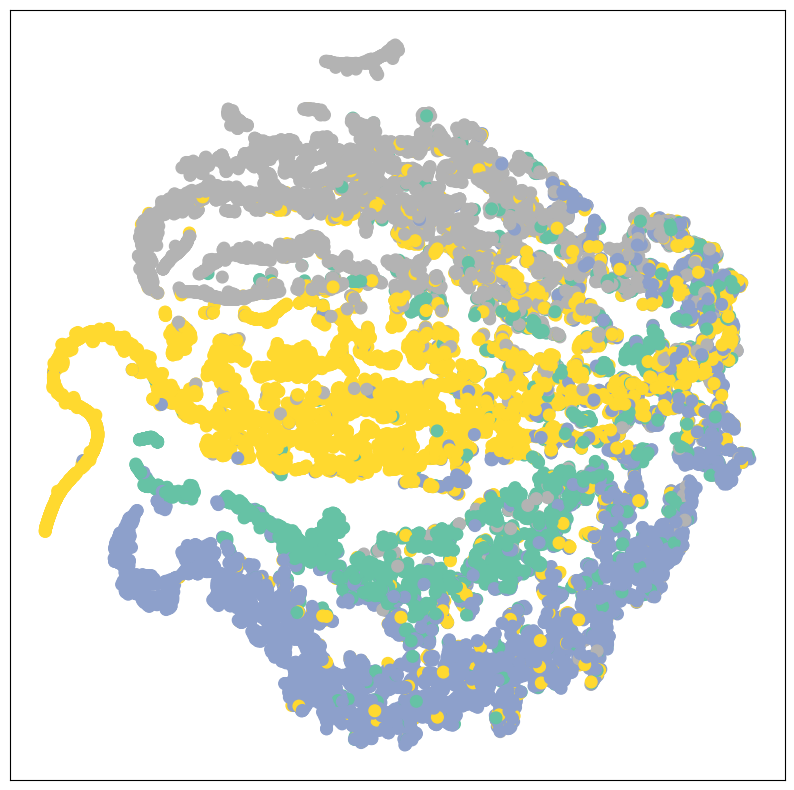

NameError: name 'out' is not defined

In [11]:
# Dataset
dataset = FacebookPagePage(root="dataset/Facebook")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Adjacency matrix
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

# MLP
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

# GCN
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)
gnn.fit(data, epochs=100)
visualize(out, color=data.y)
print(f'\nGNN test accuracy: {acc*100:.2f}%')